In [1]:
import torch
import torch.nn.functional as F
import sys
try: # whether we're on titanic or not work on my regression_classif branch at least.
    sys.path.append("/home/mathieu/local/py_script/dnadna")
    import net as net_module
except ModuleNotFoundError:
    #sys.path.append("/home/jean/Documents/ML_genetics/dnadna/")
    #import net as net_module
    print("import fail")
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def relative_position(pos):

    posd = np.diff(pos)
    npos = np.insert(posd, 0, (pos[0] - pos[-1])) % 1
    # Ensure that the original dtype is preserved, because the above line can
    # sometimes accidentally convert to a dtype not supported by pytorch
    return npos.astype(pos.dtype), pos[0]


In [3]:
dfparam = pd.read_csv('/media/mathieu/crucialmx300/exp/BacterialDemoSelection_param', sep="\t", header=0)

def compute_expected_class(scenario_name):
    expected_class = 1
    model_init = dfparam.at[int(scenario_name[9:]),'model_init']
    if 'Noselection' in model_init :
        expected_class = 0
    return expected_class

In [4]:
def sensitivity(grp):
    return sum((grp.expected_class == 1) & (grp.observed_class==1)) / (sum((grp.expected_class == 1) & (grp.observed_class==1)) + sum((grp.expected_class == 1) & (grp.observed_class==0))) 

In [5]:
def specificity(grp):
    return sum((grp.expected_class == 0) & (grp.observed_class==0)) / (sum((grp.expected_class == 0) & (grp.observed_class==0)) + sum((grp.expected_class == 0) & (grp.observed_class==1))) 

In [19]:
#Initiate network
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'cpu') # with or without gpu
net3 = net_module.CNN3(2)
net3.eval(); # to deactivate dropout and batchnorm
weight3 = torch.load("/media/mathieu/crucialmx300/exp/net/BacterialDemoSelection_run_006_last_epoch_net.pth",
                     map_location=device,
                    )
from collections import OrderedDict
new_state_dict3 = OrderedDict()
for (k, v), k2 in zip(weight3.items(), net3.state_dict().keys()):
    if k.strip("module.") in k2:
        new_state_dict3[k2] = v
    else:
        print(k, k2)
net3.load_state_dict(new_state_dict3, strict=True) 
sm = torch.nn.Softmax(dim=1)

In [20]:
#Original data
def compute_original_data_prediction(originalDatapath):
    #initiate result dataframe
    dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                                  'observed_class', 'softmax_for_observed_class','nb_SNP'])
    
    i=0
    for scenario in os.listdir(originalDatapath):
        scenardir = originalDatapath +'/'+ scenario
        for replicate in os.listdir(scenardir):
            replicatepath = scenardir + '/' + replicate

            expected_class = compute_expected_class(scenario)

            try :
                #compute prediction
                data_snp = np.load(replicatepath)
                snp, pos = data_snp["SNP"], data_snp["POS"]
                matrixLength = snp.shape[1]
                data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

                output = net3(data_in)

                val, predicted_class = torch.max(output, 1)

                predicted_class_int = predicted_class.item()               
                softmax = sm(output)
                listsm = softmax.tolist()
                softmax_float = max(listsm[0])

                if predicted_class_int !=  expected_class :
                    real_softmax_float = 1 - softmax_float
                else :
                    real_softmax_float = softmax_float

                #create new line for each replicate
                dfres.loc[i] = [scenario, replicate, 0, 0, 0, expected_class , predicted_class_int, real_softmax_float, matrixLength]
                i += 1

            except RuntimeError:
                #not enough positions ?
                print("error computing prediction for " + scenario + ':' + replicate + ': nbSNP=' + str(matrixLength))
            
    return dfres

In [21]:
#After gargammel result are in different repertories
#Repertories have different names depending which parameter have been used
#This function use the name of the repertorie to extract parameters value

def translate_real_param(dirname):
    realparam = dirname.replace('_', ' ').replace('t','-')
    params = realparam.split(',')
    coverage = params[0].split(' ')[1]
    if len(params) > 1:
        sequencing_error_param = params[1].split(' ')[1]
        sequencing_error = math.ceil(0.1 * 1/(pow(10,(int(sequencing_error_param)/10))))
    else:
        sequencing_error = 0.1
    return coverage, sequencing_error

In [22]:
#damaged data
def compute_damage_data_prediction(postGargapath):
    i=0
    #initiate result dataframe
    dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                                  'observed_class', 'softmax_for_observed_class','nb_SNP'])
    
    for degree in os.listdir(postGargapath):
        degreepath = postGargapath + '/' + degree
        if os.path.isdir(degreepath) :
            for param in os.listdir(degreepath):
                coverage, sequencing_error = translate_real_param(param)
                parampath = degreepath + '/' + param        
                for scenario in os.listdir(parampath):
                    scenariopath =  parampath +'/'+ scenario
                    for replicate in os.listdir(scenariopath):
                        replicatepath = scenariopath + '/' + replicate

                        try :

                            #compute prediction
                            data_snp = np.load(replicatepath)
                            snp, pos = data_snp["SNP"], data_snp["POS"]
                            matrixLength = snp.shape[1]
                            data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

                            output = net3(data_in)

                            val, predicted_class = torch.max(output, 1)

                            predicted_class_int = predicted_class.item()               
                            softmax = sm(output)
                            listsm = softmax.tolist()
                            softmax_float = max(listsm[0])

                            #add result in dataframe
                            expected_class = compute_expected_class(scenario)

                            if predicted_class_int != expected_class :
                                real_softmax_float = 1 - softmax_float
                            else :
                                real_softmax_float = softmax_float

                            #create new line for each replicate
                            dfres.loc[i] = [scenario, replicate[1:], degree, float(coverage), sequencing_error, expected_class, predicted_class_int, real_softmax_float, matrixLength]
                            i += 1
                        except RuntimeError:
                            #not enough positions ?
                            print("error computing prediction for " + degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error) + \
                                  '% :' + scenario + ':' + replicate[1:])
                        except IndexError:
                            print(degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error)+ scenario + ':' + replicate[1:] + " was not found")
                        
    return dfres

In [23]:
#no damage data
originalDatapath="/media/mathieu/crucialmx300/exp/ori"
dforirignal = compute_original_data_prediction(originalDatapath)

In [25]:
dforirignal

scenario                             replicate damage coverage  \
0    scenario_05414  BacterialDemoSelection_05414_000.npz      0        0   
1    scenario_05414  BacterialDemoSelection_05414_001.npz      0        0   
2    scenario_05414  BacterialDemoSelection_05414_009.npz      0        0   
3    scenario_05414  BacterialDemoSelection_05414_013.npz      0        0   
4    scenario_05414  BacterialDemoSelection_05414_025.npz      0        0   
..              ...                                   ...    ...      ...   
834  scenario_05997  BacterialDemoSelection_05997_059.npz      0        0   
835  scenario_05997  BacterialDemoSelection_05997_060.npz      0        0   
836  scenario_05997  BacterialDemoSelection_05997_073.npz      0        0   
837  scenario_05997  BacterialDemoSelection_05997_075.npz      0        0   
838  scenario_05997  BacterialDemoSelection_05997_090.npz      0        0   

    error_rate expected_class observed_class  softmax_for_observed_class  \
0            0              0              0                    0.937906   
1            0              0              0                    0.906074   
2            0              0              0                    0.923606   
3            0              0              0                    0.906543   
4            0              0              0                    0.913155   
..         ...            ...            ...                         ...   
834          0              1              1                    0.889410   
835          0              1              1                    0.897291   
836          0              1              1                    0.897126   
837          0              1              1                    0.901697   
838          0              1              1                    0.890954   

    nb_SNP  
0     1019  
1     1483  
2     1432  
3     1036  
4      943  
..     ...  
834    508  
835    496  
836    483  
837    514  
838    490  

[839 rows x 9 columns]

In [26]:
sensitivity(dforirignal)

0.5242566510172144

In [27]:
specificity(dforirignal)

1.0

In [28]:
#damage data
postGargapath="/media/mathieu/crucialmx300/exp/c2resultall"
dfres = compute_damage_data_prediction(postGargapath)

error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_002.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_007.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_015.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_029.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_033.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_079.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_080.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_089.npz
error computing prediction for high: c=1, Erate=2% :scenario_050

error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_008.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_017.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_019.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_035.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_063.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_082.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_089.npz
error computing prediction for high: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for high: c=1, Erate=2% :scenario_057

error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_066.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_092.npz
error computing prediction for high: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_004.npz
error computing prediction for high: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_023.npz
error computing prediction for high: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_026.npz
error computing prediction for high: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_038.npz
error computing prediction for high: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_040.npz
error computing prediction for high: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_065.npz
error computing prediction for high: c=1, Erate=2% :scenario_057

error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_073.npz
error computing prediction for high: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_002.npz
error computing prediction for high: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_010.npz
error computing prediction for high: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_012.npz
error computing prediction for high: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_025.npz
error computing prediction for high: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_032.npz
error computing prediction for high: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_036.npz
error computing prediction for high: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_050.npz
error computing prediction for high: c=1, Erate=2% :scenario_058

error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_022.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_030.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_041.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_052.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_058.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_059.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_072.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_073.npz
error computing prediction for high: c=1, Erate=2% :scenario_058

error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_091.npz
error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_099.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_004.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_009.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_041.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_061.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_070.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_081.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_082.npz
error computing prediction for high: c=1, Erate=2% :scenario_059

error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_026.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_066.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_079.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_086.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_087.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_090.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_098.npz
error computing prediction for high: c=1, Erate=2% :scenario_059

error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_022.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_052.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_058.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_071.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_072.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_073.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_075.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_093.npz
error computing prediction for high: c=1, Erate=2% :scenario_055

error computing prediction for high: c=1, Erate=2% :scenario_05629:BacterialDemoSelection_05629_071.npz
error computing prediction for high: c=1, Erate=2% :scenario_05629:BacterialDemoSelection_05629_095.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_017.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_029.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_032.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_040.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_049.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_070.npz
error computing prediction for high: c=1, Erate=2% :scenario_056

error computing prediction for high: c=1, Erate=2% :scenario_05679:BacterialDemoSelection_05679_056.npz
error computing prediction for high: c=1, Erate=2% :scenario_05679:BacterialDemoSelection_05679_071.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_005.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_037.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_038.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_041.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_052.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_061.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_068.npz
error computing prediction for high: c=1, Erate=2% :scenario_056

error computing prediction for high: c=1, Erate=2% :scenario_05862:BacterialDemoSelection_05862_064.npz
error computing prediction for high: c=1, Erate=2% :scenario_05862:BacterialDemoSelection_05862_097.npz
error computing prediction for high: c=2, Erate=2% :scenario_05003:BacterialDemoSelection_05003_033.npz
error computing prediction for high: c=2, Erate=2% :scenario_05505:BacterialDemoSelection_05505_093.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_009.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_013.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_017.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_025.npz
error computing prediction for high: c=2, Erate=2% :scenario_057

error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_002.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_022.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_047.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_052.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_056.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_071.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_075.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_081.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_095.npz
error computing prediction for high: c=2, Erate=2% :scenario_058

error computing prediction for high: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_040.npz
error computing prediction for high: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_044.npz
error computing prediction for high: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_075.npz
error computing prediction for high: c=2, Erate=2% :scenario_05920:BacterialDemoSelection_05920_056.npz
error computing prediction for high: c=2, Erate=2% :scenario_05920:BacterialDemoSelection_05920_057.npz
error computing prediction for high: c=2, Erate=2% :scenario_05924:BacterialDemoSelection_05924_003.npz
error computing prediction for high: c=2, Erate=2% :scenario_05924:BacterialDemoSelection_05924_010.npz
error computing prediction for high: c=2, Erate=2% :scenario_05924:BacterialDemoSelection_05924_038.npz
error computing prediction for high: c=2, Erate=2% :scenario_05924:BacterialDemoSelection_05924_075.npz
error computing prediction for high: c=2, Erate=2% :scenario_059

error computing prediction for high: c=2, Erate=2% :scenario_05576:BacterialDemoSelection_05576_038.npz
error computing prediction for high: c=2, Erate=2% :scenario_05576:BacterialDemoSelection_05576_053.npz
error computing prediction for high: c=2, Erate=2% :scenario_05576:BacterialDemoSelection_05576_068.npz
error computing prediction for high: c=2, Erate=2% :scenario_05585:BacterialDemoSelection_05585_025.npz
error computing prediction for high: c=2, Erate=2% :scenario_05585:BacterialDemoSelection_05585_062.npz
error computing prediction for high: c=2, Erate=2% :scenario_05585:BacterialDemoSelection_05585_085.npz
error computing prediction for high: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_015.npz
error computing prediction for high: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_019.npz
error computing prediction for high: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_020.npz
error computing prediction for high: c=2, Erate=2% :scenario_056

error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_051.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_070.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_096.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_000.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_017.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_043.npz
error computing prediction for high: c=2, Erate=2% :scenario_057

error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_004.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_010.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_014.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_035.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_039.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_040.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_041.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_052.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_053.npz
error computing prediction for high: c=4, Erate=2% :scenario_058

error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_022.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_070.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_081.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_085.npz
error computing prediction for high: c=8, Erate=2% :scenario_058

error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_039.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_051.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for high: c=8, Erate=2% :scenario_05725:BacterialDemoSelection_05725_070.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_007.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_015.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_029.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:B

error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_062.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_063.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_082.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_089.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_009.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_013.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_017.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_025.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_023.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_024.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_026.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_038.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_040.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_065.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_068.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_085.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_095.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_012.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_024.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_025.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_032.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_036.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_050.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_085.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_099.npz
error computing prediction for low: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_002.npz
error computing prediction for low: c=1, Erate=2% :scenario_05823:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_022.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_070.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_081.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_085.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_077.npz
error computing prediction for low: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_083.npz
error computing prediction for low: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_006.npz
error computing prediction for low: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_012.npz
error computing prediction for low: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_025.npz
error computing prediction for low: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_056.npz
error computing prediction for low: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_057.npz
error computing prediction for low: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_063.npz
error computing prediction for low: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_067.npz
error computing prediction for low: c=1, Erate=2% :scenario_05920:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_069.npz
error computing prediction for low: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_073.npz
error computing prediction for low: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_004.npz
error computing prediction for low: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_013.npz
error computing prediction for low: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_027.npz
error computing prediction for low: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_035.npz
error computing prediction for low: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_043.npz
error computing prediction for low: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_045.npz
error computing prediction for low: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_052.npz
error computing prediction for low: c=1, Erate=2% :scenario_05986:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_059.npz
error computing prediction for low: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_069.npz
error computing prediction for low: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_092.npz
error computing prediction for low: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_095.npz
error computing prediction for low: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_001.npz
error computing prediction for low: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_004.npz
error computing prediction for low: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_017.npz
error computing prediction for low: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_025.npz
error computing prediction for low: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_037.npz
error computing prediction for low: c=1, Erate=2% :scenario_05576:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05654:BacterialDemoSelection_05654_081.npz
error computing prediction for low: c=1, Erate=2% :scenario_05654:BacterialDemoSelection_05654_084.npz
error computing prediction for low: c=1, Erate=2% :scenario_05654:BacterialDemoSelection_05654_091.npz
error computing prediction for low: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_004.npz
error computing prediction for low: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_020.npz
error computing prediction for low: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_026.npz
error computing prediction for low: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_030.npz
error computing prediction for low: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_047.npz
error computing prediction for low: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_061.npz
error computing prediction for low: c=1, Erate=2% :scenario_05657:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05705:BacterialDemoSelection_05705_092.npz
error computing prediction for low: c=1, Erate=2% :scenario_05705:BacterialDemoSelection_05705_095.npz
error computing prediction for low: c=1, Erate=2% :scenario_05716:BacterialDemoSelection_05716_009.npz
error computing prediction for low: c=1, Erate=2% :scenario_05716:BacterialDemoSelection_05716_015.npz
error computing prediction for low: c=1, Erate=2% :scenario_05716:BacterialDemoSelection_05716_017.npz
error computing prediction for low: c=1, Erate=2% :scenario_05716:BacterialDemoSelection_05716_043.npz
error computing prediction for low: c=1, Erate=2% :scenario_05716:BacterialDemoSelection_05716_045.npz
error computing prediction for low: c=1, Erate=2% :scenario_05716:BacterialDemoSelection_05716_057.npz
error computing prediction for low: c=1, Erate=2% :scenario_05716:BacterialDemoSelection_05716_063.npz
error computing prediction for low: c=1, Erate=2% :scenario_05716:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_012.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_013.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_014.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_015.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_038.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_047.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_051.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_053.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_058.npz
error computing prediction for low: c=2, Erate=2% :scenario_05743:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_030.npz
error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_041.npz
error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_051.npz
error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_052.npz
error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_058.npz
error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_059.npz
error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_072.npz
error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_073.npz
error computing prediction for low: c=2, Erate=2% :scenario_05853:BacterialDemoSelection_05853_075.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05927:BacterialDemoSelection_05927_085.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:BacterialDemoSelection_05933_020.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:BacterialDemoSelection_05933_027.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:BacterialDemoSelection_05933_033.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:BacterialDemoSelection_05933_035.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:BacterialDemoSelection_05933_043.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:BacterialDemoSelection_05933_046.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:BacterialDemoSelection_05933_063.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:BacterialDemoSelection_05933_075.npz
error computing prediction for low: c=2, Erate=2% :scenario_05933:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_086.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:BacterialDemoSelection_05629_005.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:BacterialDemoSelection_05629_028.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:BacterialDemoSelection_05629_030.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:BacterialDemoSelection_05629_035.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:BacterialDemoSelection_05629_038.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:BacterialDemoSelection_05629_041.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:BacterialDemoSelection_05629_043.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:BacterialDemoSelection_05629_051.npz
error computing prediction for low: c=2, Erate=2% :scenario_05629:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_095.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:BacterialDemoSelection_05716_009.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:BacterialDemoSelection_05716_015.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:BacterialDemoSelection_05716_017.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:BacterialDemoSelection_05716_043.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:BacterialDemoSelection_05716_045.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:BacterialDemoSelection_05716_057.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:BacterialDemoSelection_05716_063.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:BacterialDemoSelection_05716_067.npz
error computing prediction for low: c=2, Erate=2% :scenario_05716:Bacteri

error computing prediction for low: c=4, Erate=2% :scenario_05871:BacterialDemoSelection_05871_028.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_000.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_006.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_007.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_015.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_018.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_031.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_033.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_049.npz
error computing prediction for low: c=4, Erate=2% :scenario_05887:Bacteri

error computing prediction for low: c=4, Erate=2% :scenario_05679:BacterialDemoSelection_05679_071.npz
error computing prediction for low: c=4, Erate=2% :scenario_05687:BacterialDemoSelection_05687_001.npz
error computing prediction for low: c=4, Erate=2% :scenario_05687:BacterialDemoSelection_05687_051.npz
error computing prediction for low: c=4, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for low: c=4, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for low: c=8, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for low: c=8, Erate=2% :scenario_05727:BacterialDemoSelection_05727_013.npz
error computing prediction for low: c=8, Erate=2% :scenario_05727:BacterialDemoSelection_05727_034.npz
error computing prediction for low: c=8, Erate=2% :scenario_05727:BacterialDemoSelection_05727_045.npz
error computing prediction for low: c=8, Erate=2% :scenario_05773:Bacteri

error computing prediction for low: c=8, Erate=2% :scenario_05997:BacterialDemoSelection_05997_087.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_003.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_022.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_025.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_052.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_053.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_058.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_059.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_069.npz
error computing prediction for low: c=8, Erate=2% :scenario_05571:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05120:BacterialDemoSelection_05120_088.npz
error computing prediction for med: c=1, Erate=2% :scenario_05120:BacterialDemoSelection_05120_089.npz
error computing prediction for med: c=1, Erate=2% :scenario_05120:BacterialDemoSelection_05120_097.npz
error computing prediction for med: c=1, Erate=2% :scenario_05149:BacterialDemoSelection_05149_020.npz
error computing prediction for med: c=1, Erate=2% :scenario_05149:BacterialDemoSelection_05149_039.npz
error computing prediction for med: c=1, Erate=2% :scenario_05149:BacterialDemoSelection_05149_089.npz
error computing prediction for med: c=1, Erate=2% :scenario_05205:BacterialDemoSelection_05205_022.npz
error computing prediction for med: c=1, Erate=2% :scenario_05205:BacterialDemoSelection_05205_049.npz
error computing prediction for med: c=1, Erate=2% :scenario_05211:BacterialDemoSelection_05211_016.npz
error computing prediction for med: c=1, Erate=2% :scenario_05211:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05737:BacterialDemoSelection_05737_069.npz
error computing prediction for med: c=1, Erate=2% :scenario_05737:BacterialDemoSelection_05737_072.npz
error computing prediction for med: c=1, Erate=2% :scenario_05737:BacterialDemoSelection_05737_076.npz
error computing prediction for med: c=1, Erate=2% :scenario_05737:BacterialDemoSelection_05737_077.npz
error computing prediction for med: c=1, Erate=2% :scenario_05737:BacterialDemoSelection_05737_078.npz
error computing prediction for med: c=1, Erate=2% :scenario_05740:BacterialDemoSelection_05740_009.npz
error computing prediction for med: c=1, Erate=2% :scenario_05740:BacterialDemoSelection_05740_021.npz
error computing prediction for med: c=1, Erate=2% :scenario_05740:BacterialDemoSelection_05740_028.npz
error computing prediction for med: c=1, Erate=2% :scenario_05740:BacterialDemoSelection_05740_030.npz
error computing prediction for med: c=1, Erate=2% :scenario_05740:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_008.npz
error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_022.npz
error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_024.npz
error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_034.npz
error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_037.npz
error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_050.npz
error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_056.npz
error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_062.npz
error computing prediction for med: c=1, Erate=2% :scenario_05784:BacterialDemoSelection_05784_085.npz
error computing prediction for med: c=1, Erate=2% :scenario_05796:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05836:BacterialDemoSelection_05836_090.npz
error computing prediction for med: c=1, Erate=2% :scenario_05836:BacterialDemoSelection_05836_098.npz
error computing prediction for med: c=1, Erate=2% :scenario_05840:BacterialDemoSelection_05840_004.npz
error computing prediction for med: c=1, Erate=2% :scenario_05840:BacterialDemoSelection_05840_009.npz
error computing prediction for med: c=1, Erate=2% :scenario_05840:BacterialDemoSelection_05840_019.npz
error computing prediction for med: c=1, Erate=2% :scenario_05840:BacterialDemoSelection_05840_023.npz
error computing prediction for med: c=1, Erate=2% :scenario_05840:BacterialDemoSelection_05840_026.npz
error computing prediction for med: c=1, Erate=2% :scenario_05840:BacterialDemoSelection_05840_034.npz
error computing prediction for med: c=1, Erate=2% :scenario_05840:BacterialDemoSelection_05840_045.npz
error computing prediction for med: c=1, Erate=2% :scenario_05840:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05894:BacterialDemoSelection_05894_033.npz
error computing prediction for med: c=1, Erate=2% :scenario_05894:BacterialDemoSelection_05894_037.npz
error computing prediction for med: c=1, Erate=2% :scenario_05894:BacterialDemoSelection_05894_047.npz
error computing prediction for med: c=1, Erate=2% :scenario_05894:BacterialDemoSelection_05894_055.npz
error computing prediction for med: c=1, Erate=2% :scenario_05894:BacterialDemoSelection_05894_081.npz
error computing prediction for med: c=1, Erate=2% :scenario_05894:BacterialDemoSelection_05894_084.npz
error computing prediction for med: c=1, Erate=2% :scenario_05899:BacterialDemoSelection_05899_004.npz
error computing prediction for med: c=1, Erate=2% :scenario_05899:BacterialDemoSelection_05899_010.npz
error computing prediction for med: c=1, Erate=2% :scenario_05899:BacterialDemoSelection_05899_014.npz
error computing prediction for med: c=1, Erate=2% :scenario_05899:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05930:BacterialDemoSelection_05930_064.npz
error computing prediction for med: c=1, Erate=2% :scenario_05930:BacterialDemoSelection_05930_070.npz
error computing prediction for med: c=1, Erate=2% :scenario_05930:BacterialDemoSelection_05930_071.npz
error computing prediction for med: c=1, Erate=2% :scenario_05930:BacterialDemoSelection_05930_094.npz
error computing prediction for med: c=1, Erate=2% :scenario_05933:BacterialDemoSelection_05933_014.npz
error computing prediction for med: c=1, Erate=2% :scenario_05933:BacterialDemoSelection_05933_020.npz
error computing prediction for med: c=1, Erate=2% :scenario_05933:BacterialDemoSelection_05933_027.npz
error computing prediction for med: c=1, Erate=2% :scenario_05933:BacterialDemoSelection_05933_033.npz
error computing prediction for med: c=1, Erate=2% :scenario_05933:BacterialDemoSelection_05933_035.npz
error computing prediction for med: c=1, Erate=2% :scenario_05933:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_005.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_027.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_033.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_042.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_059.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_060.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_073.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_075.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_087.npz
error computing prediction for med: c=1, Erate=2% :scenario_05997:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_015.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_019.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_020.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_035.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_041.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_055.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_068.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_070.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_073.npz
error computing prediction for med: c=1, Erate=2% :scenario_05611:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_092.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_014.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_029.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_032.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_034.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_059.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_072.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_075.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_088.npz
error computing prediction for med: c=1, Erate=2% :scenario_05676:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_013.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_031.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_049.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_058.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_059.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_063.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_070.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_094.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_098.npz
error computing prediction for med: c=1, Erate=2% :scenario_05862:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_003.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_006.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_010.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_021.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_045.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_054.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_056.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_059.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:BacterialDemoSelection_05851_062.npz
error computing prediction for med: c=2, Erate=2% :scenario_05851:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_012.npz
error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_029.npz
error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_034.npz
error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_036.npz
error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_043.npz
error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_053.npz
error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_055.npz
error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_069.npz
error computing prediction for med: c=2, Erate=2% :scenario_05967:BacterialDemoSelection_05967_073.npz
error computing prediction for med: c=2, Erate=2% :scenario_05987:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05673:BacterialDemoSelection_05673_064.npz
error computing prediction for med: c=2, Erate=2% :scenario_05673:BacterialDemoSelection_05673_083.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_009.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_014.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_022.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_025.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_034.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_040.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_044.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:Bacteri

error computing prediction for med: c=8, Erate=2% :scenario_05851:BacterialDemoSelection_05851_059.npz
error computing prediction for med: c=8, Erate=2% :scenario_05851:BacterialDemoSelection_05851_062.npz
error computing prediction for med: c=8, Erate=2% :scenario_05851:BacterialDemoSelection_05851_071.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_022.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:Bacteri

In [29]:
sensitivity(dfres)

0.8664654998994166

In [30]:
specificity(dfres)

0.5713878597891137

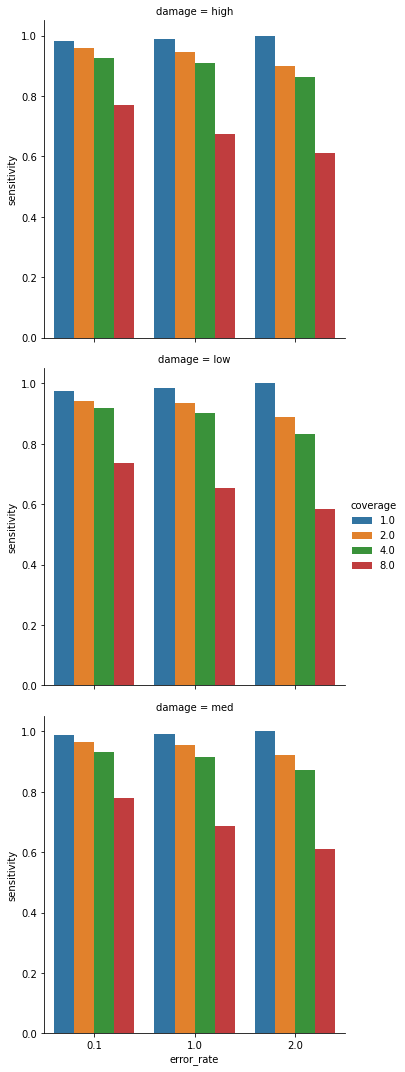

In [32]:
df_sens = dfres.groupby(["damage", "error_rate", "coverage"]).apply(sensitivity).to_frame("sensitivity").reset_index()

chart = sns.catplot(data=df_sens, y="sensitivity", x="error_rate", hue="coverage", kind="bar",row='damage', legend_out=True)

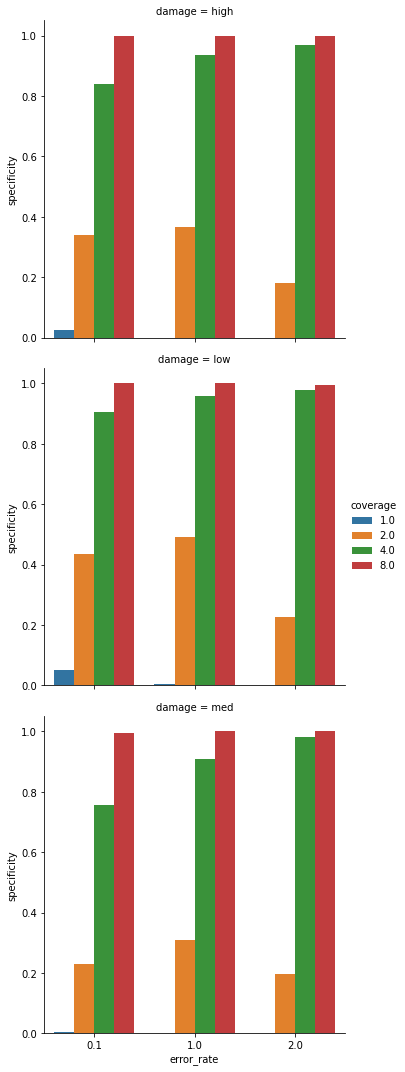

In [33]:
df_spe = dfres.groupby(["damage", "error_rate", "coverage"]).apply(specificity).to_frame("specificity").reset_index()
chart = sns.catplot(data=df_spe, y="specificity", x="error_rate", hue="coverage", row="damage", kind="bar", legend_out=True)

<h1>Without dropout</h1>

In [34]:
#Initiate network
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'cpu') # with or without gpu
net3 = net_module.CNN3(2)
#net3.eval(); # to deactivate dropout and batchnorm
weight3 = torch.load("/media/mathieu/crucialmx300/exp/net/BacterialDemoSelection_run_006_last_epoch_net.pth",
                     map_location=device,
                    )
from collections import OrderedDict
new_state_dict3 = OrderedDict()
for (k, v), k2 in zip(weight3.items(), net3.state_dict().keys()):
    if k.strip("module.") in k2:
        new_state_dict3[k2] = v
    else:
        print(k, k2)
net3.load_state_dict(new_state_dict3, strict=True) 
sm = torch.nn.Softmax(dim=1)

In [35]:
#no damage data
originalDatapath="/media/mathieu/crucialmx300/exp/ori"
dforirignal = compute_original_data_prediction(originalDatapath)

In [36]:
sensitivity(dforirignal)

0.9780907668231612

In [37]:
specificity(dforirignal)

0.05

In [40]:
#damage data
postGargapath="/media/mathieu/crucialmx300/exp/c2resultall"
dfres = compute_damage_data_prediction(postGargapath)

error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_002.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_007.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_015.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_029.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_033.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_079.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_080.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_089.npz
error computing prediction for high: c=1, Erate=2% :scenario_050

error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_002.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_008.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_017.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_019.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_035.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_063.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_082.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_089.npz
error computing prediction for high: c=1, Erate=2% :scenario_057

error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_004.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_013.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_016.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_044.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_056.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_063.npz
error computing prediction for high: c=1, Erate=2% :scenario_05757:BacterialDemoSelection_05757_066.npz
error computing prediction for high: c=1, Erate=2% :scenario_057

error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_001.npz
error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_003.npz
error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_020.npz
error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_025.npz
error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_026.npz
error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_052.npz
error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_054.npz
error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_068.npz
error computing prediction for high: c=1, Erate=2% :scenario_05807:BacterialDemoSelection_05807_069.npz
error computing prediction for high: c=1, Erate=2% :scenario_058

error computing prediction for high: c=1, Erate=2% :scenario_05851:BacterialDemoSelection_05851_021.npz
error computing prediction for high: c=1, Erate=2% :scenario_05851:BacterialDemoSelection_05851_045.npz
error computing prediction for high: c=1, Erate=2% :scenario_05851:BacterialDemoSelection_05851_054.npz
error computing prediction for high: c=1, Erate=2% :scenario_05851:BacterialDemoSelection_05851_056.npz
error computing prediction for high: c=1, Erate=2% :scenario_05851:BacterialDemoSelection_05851_059.npz
error computing prediction for high: c=1, Erate=2% :scenario_05851:BacterialDemoSelection_05851_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05851:BacterialDemoSelection_05851_071.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_022.npz
error computing prediction for high: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_030.npz
error computing prediction for high: c=1, Erate=2% :scenario_058

error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_044.npz
error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_070.npz
error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_075.npz
error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_091.npz
error computing prediction for high: c=1, Erate=2% :scenario_05906:BacterialDemoSelection_05906_099.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_004.npz
error computing prediction for high: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_009.npz
error computing prediction for high: c=1, Erate=2% :scenario_059

error computing prediction for high: c=1, Erate=2% :scenario_05948:BacterialDemoSelection_05948_079.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_018.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_026.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_066.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_079.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_086.npz
error computing prediction for high: c=1, Erate=2% :scenario_05951:BacterialDemoSelection_05951_087.npz
error computing prediction for high: c=1, Erate=2% :scenario_059

error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_007.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_022.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_052.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_058.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_071.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_072.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_073.npz
error computing prediction for high: c=1, Erate=2% :scenario_05550:BacterialDemoSelection_05550_075.npz
error computing prediction for high: c=1, Erate=2% :scenario_055

error computing prediction for high: c=1, Erate=2% :scenario_05629:BacterialDemoSelection_05629_038.npz
error computing prediction for high: c=1, Erate=2% :scenario_05629:BacterialDemoSelection_05629_041.npz
error computing prediction for high: c=1, Erate=2% :scenario_05629:BacterialDemoSelection_05629_043.npz
error computing prediction for high: c=1, Erate=2% :scenario_05629:BacterialDemoSelection_05629_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05629:BacterialDemoSelection_05629_071.npz
error computing prediction for high: c=1, Erate=2% :scenario_05629:BacterialDemoSelection_05629_095.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_017.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_029.npz
error computing prediction for high: c=1, Erate=2% :scenario_056

error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_005.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_037.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_038.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_041.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_052.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_061.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_068.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_079.npz
error computing prediction for high: c=1, Erate=2% :scenario_05685:BacterialDemoSelection_05685_080.npz
error computing prediction for high: c=1, Erate=2% :scenario_056

error computing prediction for high: c=2, Erate=2% :scenario_05003:BacterialDemoSelection_05003_033.npz
error computing prediction for high: c=2, Erate=2% :scenario_05505:BacterialDemoSelection_05505_093.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_009.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_013.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_017.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_025.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_034.npz
error computing prediction for high: c=2, Erate=2% :scenario_05727:BacterialDemoSelection_05727_045.npz
error computing prediction for high: c=2, Erate=2% :scenario_057

error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_002.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_022.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_047.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_052.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_056.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_071.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_075.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_081.npz
error computing prediction for high: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_095.npz
error computing prediction for high: c=2, Erate=2% :scenario_058

error computing prediction for high: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_040.npz
error computing prediction for high: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_044.npz
error computing prediction for high: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_075.npz
error computing prediction for high: c=2, Erate=2% :scenario_05920:BacterialDemoSelection_05920_056.npz
error computing prediction for high: c=2, Erate=2% :scenario_05920:BacterialDemoSelection_05920_057.npz
error computing prediction for high: c=2, Erate=2% :scenario_05924:BacterialDemoSelection_05924_003.npz
error computing prediction for high: c=2, Erate=2% :scenario_05924:BacterialDemoSelection_05924_010.npz
error computing prediction for high: c=2, Erate=2% :scenario_05924:BacterialDemoSelection_05924_038.npz
error computing prediction for high: c=2, Erate=2% :scenario_05924:BacterialDemoSelection_05924_075.npz
error computing prediction for high: c=2, Erate=2% :scenario_059

error computing prediction for high: c=2, Erate=2% :scenario_05576:BacterialDemoSelection_05576_038.npz
error computing prediction for high: c=2, Erate=2% :scenario_05576:BacterialDemoSelection_05576_053.npz
error computing prediction for high: c=2, Erate=2% :scenario_05576:BacterialDemoSelection_05576_068.npz
error computing prediction for high: c=2, Erate=2% :scenario_05585:BacterialDemoSelection_05585_025.npz
error computing prediction for high: c=2, Erate=2% :scenario_05585:BacterialDemoSelection_05585_062.npz
error computing prediction for high: c=2, Erate=2% :scenario_05585:BacterialDemoSelection_05585_085.npz
error computing prediction for high: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_015.npz
error computing prediction for high: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_019.npz
error computing prediction for high: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_020.npz
error computing prediction for high: c=2, Erate=2% :scenario_056

error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_039.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_051.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_070.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_096.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_000.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_017.npz
error computing prediction for high: c=2, Erate=2% :scenario_057

error computing prediction for high: c=4, Erate=2% :scenario_05887:BacterialDemoSelection_05887_054.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_004.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_010.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_014.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_035.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_039.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_040.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_041.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_052.npz
error computing prediction for high: c=4, Erate=2% :scenario_058

error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_022.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_070.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_081.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_085.npz
error computing prediction for high: c=8, Erate=2% :scenario_058

error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_039.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_051.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for high: c=8, Erate=2% :scenario_05725:BacterialDemoSelection_05725_070.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_007.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_015.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_029.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:B

error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_008.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_017.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_019.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_035.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_062.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_063.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_082.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_089.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_023.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_024.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_026.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_038.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_040.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_065.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_068.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_085.npz
error computing prediction for low: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_095.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_010.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_012.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_024.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_025.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_032.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_036.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_050.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_085.npz
error computing prediction for low: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_099.npz
error computing prediction for low: c=1, Erate=2% :scenario_05823:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_073.npz
error computing prediction for low: c=1, Erate=2% :scenario_05853:BacterialDemoSelection_05853_075.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_022.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_070.npz
error computing prediction for low: c=1, Erate=2% :scenario_05859:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_082.npz
error computing prediction for low: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_086.npz
error computing prediction for low: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_087.npz
error computing prediction for low: c=1, Erate=2% :scenario_05912:BacterialDemoSelection_05912_098.npz
error computing prediction for low: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_008.npz
error computing prediction for low: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_014.npz
error computing prediction for low: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_019.npz
error computing prediction for low: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_020.npz
error computing prediction for low: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_031.npz
error computing prediction for low: c=1, Erate=2% :scenario_05914:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05954:BacterialDemoSelection_05954_059.npz
error computing prediction for low: c=1, Erate=2% :scenario_05954:BacterialDemoSelection_05954_061.npz
error computing prediction for low: c=1, Erate=2% :scenario_05954:BacterialDemoSelection_05954_062.npz
error computing prediction for low: c=1, Erate=2% :scenario_05954:BacterialDemoSelection_05954_065.npz
error computing prediction for low: c=1, Erate=2% :scenario_05954:BacterialDemoSelection_05954_066.npz
error computing prediction for low: c=1, Erate=2% :scenario_05954:BacterialDemoSelection_05954_092.npz
error computing prediction for low: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_012.npz
error computing prediction for low: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_029.npz
error computing prediction for low: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_034.npz
error computing prediction for low: c=1, Erate=2% :scenario_05967:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_026.npz
error computing prediction for low: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_041.npz
error computing prediction for low: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_061.npz
error computing prediction for low: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_065.npz
error computing prediction for low: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_070.npz
error computing prediction for low: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_095.npz
error computing prediction for low: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_096.npz
error computing prediction for low: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_003.npz
error computing prediction for low: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_022.npz
error computing prediction for low: c=1, Erate=2% :scenario_05571:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_074.npz
error computing prediction for low: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_081.npz
error computing prediction for low: c=1, Erate=2% :scenario_05639:BacterialDemoSelection_05639_092.npz
error computing prediction for low: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_000.npz
error computing prediction for low: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_029.npz
error computing prediction for low: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_048.npz
error computing prediction for low: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_051.npz
error computing prediction for low: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_052.npz
error computing prediction for low: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_057.npz
error computing prediction for low: c=1, Erate=2% :scenario_05651:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_070.npz
error computing prediction for low: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for low: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_096.npz
error computing prediction for low: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for low: c=1, Erate=2% :scenario_05694:BacterialDemoSelection_05694_003.npz
error computing prediction for low: c=1, Erate=2% :scenario_05694:BacterialDemoSelection_05694_013.npz
error computing prediction for low: c=1, Erate=2% :scenario_05694:BacterialDemoSelection_05694_015.npz
error computing prediction for low: c=1, Erate=2% :scenario_05694:BacterialDemoSelection_05694_019.npz
error computing prediction for low: c=1, Erate=2% :scenario_05694:BacterialDemoSelection_05694_022.npz
error computing prediction for low: c=1, Erate=2% :scenario_05694:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05730:BacterialDemoSelection_05730_070.npz
error computing prediction for low: c=2, Erate=2% :scenario_05736:BacterialDemoSelection_05736_004.npz
error computing prediction for low: c=2, Erate=2% :scenario_05736:BacterialDemoSelection_05736_014.npz
error computing prediction for low: c=2, Erate=2% :scenario_05736:BacterialDemoSelection_05736_042.npz
error computing prediction for low: c=2, Erate=2% :scenario_05736:BacterialDemoSelection_05736_079.npz
error computing prediction for low: c=2, Erate=2% :scenario_05736:BacterialDemoSelection_05736_080.npz
error computing prediction for low: c=2, Erate=2% :scenario_05736:BacterialDemoSelection_05736_087.npz
error computing prediction for low: c=2, Erate=2% :scenario_05736:BacterialDemoSelection_05736_095.npz
error computing prediction for low: c=2, Erate=2% :scenario_05737:BacterialDemoSelection_05737_029.npz
error computing prediction for low: c=2, Erate=2% :scenario_05737:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_098.npz
error computing prediction for low: c=2, Erate=2% :scenario_05830:BacterialDemoSelection_05830_012.npz
error computing prediction for low: c=2, Erate=2% :scenario_05830:BacterialDemoSelection_05830_024.npz
error computing prediction for low: c=2, Erate=2% :scenario_05830:BacterialDemoSelection_05830_025.npz
error computing prediction for low: c=2, Erate=2% :scenario_05830:BacterialDemoSelection_05830_048.npz
error computing prediction for low: c=2, Erate=2% :scenario_05830:BacterialDemoSelection_05830_074.npz
error computing prediction for low: c=2, Erate=2% :scenario_05830:BacterialDemoSelection_05830_076.npz
error computing prediction for low: c=2, Erate=2% :scenario_05830:BacterialDemoSelection_05830_077.npz
error computing prediction for low: c=2, Erate=2% :scenario_05830:BacterialDemoSelection_05830_081.npz
error computing prediction for low: c=2, Erate=2% :scenario_05850:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_077.npz
error computing prediction for low: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_037.npz
error computing prediction for low: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_040.npz
error computing prediction for low: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_044.npz
error computing prediction for low: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_062.npz
error computing prediction for low: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_070.npz
error computing prediction for low: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_075.npz
error computing prediction for low: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_091.npz
error computing prediction for low: c=2, Erate=2% :scenario_05906:BacterialDemoSelection_05906_099.npz
error computing prediction for low: c=2, Erate=2% :scenario_05920:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05997:BacterialDemoSelection_05997_090.npz
error computing prediction for low: c=2, Erate=2% :scenario_05548:BacterialDemoSelection_05548_067.npz
error computing prediction for low: c=2, Erate=2% :scenario_05550:BacterialDemoSelection_05550_007.npz
error computing prediction for low: c=2, Erate=2% :scenario_05550:BacterialDemoSelection_05550_072.npz
error computing prediction for low: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_003.npz
error computing prediction for low: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_022.npz
error computing prediction for low: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_025.npz
error computing prediction for low: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_052.npz
error computing prediction for low: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_053.npz
error computing prediction for low: c=2, Erate=2% :scenario_05571:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_009.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_014.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_022.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_025.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_034.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_040.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_044.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_055.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_056.npz
error computing prediction for low: c=2, Erate=2% :scenario_05679:Bacteri

error computing prediction for low: c=4, Erate=2% :scenario_05807:BacterialDemoSelection_05807_069.npz
error computing prediction for low: c=4, Erate=2% :scenario_05807:BacterialDemoSelection_05807_073.npz
error computing prediction for low: c=4, Erate=2% :scenario_05823:BacterialDemoSelection_05823_002.npz
error computing prediction for low: c=4, Erate=2% :scenario_05823:BacterialDemoSelection_05823_022.npz
error computing prediction for low: c=4, Erate=2% :scenario_05823:BacterialDemoSelection_05823_047.npz
error computing prediction for low: c=4, Erate=2% :scenario_05823:BacterialDemoSelection_05823_056.npz
error computing prediction for low: c=4, Erate=2% :scenario_05823:BacterialDemoSelection_05823_071.npz
error computing prediction for low: c=4, Erate=2% :scenario_05823:BacterialDemoSelection_05823_075.npz
error computing prediction for low: c=4, Erate=2% :scenario_05823:BacterialDemoSelection_05823_081.npz
error computing prediction for low: c=4, Erate=2% :scenario_05851:Bacteri

error computing prediction for low: c=4, Erate=2% :scenario_05611:BacterialDemoSelection_05611_086.npz
error computing prediction for low: c=4, Erate=2% :scenario_05639:BacterialDemoSelection_05639_017.npz
error computing prediction for low: c=4, Erate=2% :scenario_05639:BacterialDemoSelection_05639_024.npz
error computing prediction for low: c=4, Erate=2% :scenario_05639:BacterialDemoSelection_05639_029.npz
error computing prediction for low: c=4, Erate=2% :scenario_05639:BacterialDemoSelection_05639_032.npz
error computing prediction for low: c=4, Erate=2% :scenario_05639:BacterialDemoSelection_05639_049.npz
error computing prediction for low: c=4, Erate=2% :scenario_05639:BacterialDemoSelection_05639_070.npz
error computing prediction for low: c=4, Erate=2% :scenario_05639:BacterialDemoSelection_05639_074.npz
error computing prediction for low: c=4, Erate=2% :scenario_05639:BacterialDemoSelection_05639_081.npz
error computing prediction for low: c=4, Erate=2% :scenario_05651:Bacteri

error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_000.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_006.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_007.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_015.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_018.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_031.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_033.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_049.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:BacterialDemoSelection_05887_054.npz
error computing prediction for low: c=8, Erate=2% :scenario_05887:Bacteri

error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_071.npz
error computing prediction for low: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_039.npz
error computing prediction for low: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_051.npz
error computing prediction for low: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for low: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for low: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for med: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_002.npz
error computing prediction for med: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_007.npz
error computing prediction for med: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_015.npz
error computing prediction for med: c=1, Erate=2% :scenario_05003:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_009.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_013.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_017.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_025.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_034.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_045.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_050.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_053.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_082.npz
error computing prediction for med: c=1, Erate=2% :scenario_05730:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_068.npz
error computing prediction for med: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_085.npz
error computing prediction for med: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_095.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_008.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_012.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_024.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_044.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_051.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_054.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_056.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_071.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_075.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_081.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_095.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_098.npz
error computing prediction for med: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_012.npz
error computing prediction for med: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_024.npz
error computing prediction for med: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_025.npz
error computing prediction for med: c=1, Erate=2% :scenario_05830:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05859:BacterialDemoSelection_05859_089.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_003.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_005.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_006.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_010.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_011.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_028.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_062.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_081.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_077.npz
error computing prediction for med: c=1, Erate=2% :scenario_05914:BacterialDemoSelection_05914_083.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_006.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_012.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_025.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_056.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_057.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_063.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_067.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_012.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_029.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_034.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_036.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_040.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_043.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_053.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_055.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:BacterialDemoSelection_05967_069.npz
error computing prediction for med: c=1, Erate=2% :scenario_05967:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_065.npz
error computing prediction for med: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_070.npz
error computing prediction for med: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_095.npz
error computing prediction for med: c=1, Erate=2% :scenario_05558:BacterialDemoSelection_05558_096.npz
error computing prediction for med: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_003.npz
error computing prediction for med: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_022.npz
error computing prediction for med: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_025.npz
error computing prediction for med: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_052.npz
error computing prediction for med: c=1, Erate=2% :scenario_05571:BacterialDemoSelection_05571_053.npz
error computing prediction for med: c=1, Erate=2% :scenario_05571:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_029.npz
error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_048.npz
error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_051.npz
error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_052.npz
error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_057.npz
error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_059.npz
error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_064.npz
error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_073.npz
error computing prediction for med: c=1, Erate=2% :scenario_05651:BacterialDemoSelection_05651_091.npz
error computing prediction for med: c=1, Erate=2% :scenario_05654:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_051.npz
error computing prediction for med: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for med: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_070.npz
error computing prediction for med: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for med: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_096.npz
error computing prediction for med: c=1, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for med: c=1, Erate=2% :scenario_05694:BacterialDemoSelection_05694_003.npz
error computing prediction for med: c=1, Erate=2% :scenario_05694:BacterialDemoSelection_05694_013.npz
error computing prediction for med: c=1, Erate=2% :scenario_05694:BacterialDemoSelection_05694_015.npz
error computing prediction for med: c=1, Erate=2% :scenario_05694:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05740:BacterialDemoSelection_05740_059.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_012.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_013.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_015.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_038.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_047.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_051.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_053.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:BacterialDemoSelection_05743_058.npz
error computing prediction for med: c=2, Erate=2% :scenario_05743:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05871:BacterialDemoSelection_05871_095.npz
error computing prediction for med: c=2, Erate=2% :scenario_05885:BacterialDemoSelection_05885_016.npz
error computing prediction for med: c=2, Erate=2% :scenario_05885:BacterialDemoSelection_05885_032.npz
error computing prediction for med: c=2, Erate=2% :scenario_05885:BacterialDemoSelection_05885_068.npz
error computing prediction for med: c=2, Erate=2% :scenario_05885:BacterialDemoSelection_05885_085.npz
error computing prediction for med: c=2, Erate=2% :scenario_05887:BacterialDemoSelection_05887_000.npz
error computing prediction for med: c=2, Erate=2% :scenario_05887:BacterialDemoSelection_05887_006.npz
error computing prediction for med: c=2, Erate=2% :scenario_05887:BacterialDemoSelection_05887_007.npz
error computing prediction for med: c=2, Erate=2% :scenario_05887:BacterialDemoSelection_05887_015.npz
error computing prediction for med: c=2, Erate=2% :scenario_05887:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_092.npz
error computing prediction for med: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_095.npz
error computing prediction for med: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_015.npz
error computing prediction for med: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_019.npz
error computing prediction for med: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_020.npz
error computing prediction for med: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_035.npz
error computing prediction for med: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_041.npz
error computing prediction for med: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_055.npz
error computing prediction for med: c=2, Erate=2% :scenario_05611:BacterialDemoSelection_05611_068.npz
error computing prediction for med: c=2, Erate=2% :scenario_05611:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05517:BacterialDemoSelection_05517_051.npz
error computing prediction for med: c=2, Erate=2% :scenario_05517:BacterialDemoSelection_05517_062.npz
error computing prediction for med: c=2, Erate=2% :scenario_05517:BacterialDemoSelection_05517_087.npz
error computing prediction for med: c=2, Erate=2% :scenario_05517:BacterialDemoSelection_05517_088.npz
error computing prediction for med: c=2, Erate=2% :scenario_05725:BacterialDemoSelection_05725_003.npz
error computing prediction for med: c=2, Erate=2% :scenario_05725:BacterialDemoSelection_05725_013.npz
error computing prediction for med: c=2, Erate=2% :scenario_05725:BacterialDemoSelection_05725_031.npz
error computing prediction for med: c=2, Erate=2% :scenario_05725:BacterialDemoSelection_05725_049.npz
error computing prediction for med: c=2, Erate=2% :scenario_05725:BacterialDemoSelection_05725_058.npz
error computing prediction for med: c=2, Erate=2% :scenario_05725:Bacteri

error computing prediction for med: c=8, Erate=2% :scenario_05927:BacterialDemoSelection_05927_011.npz
error computing prediction for med: c=8, Erate=2% :scenario_05927:BacterialDemoSelection_05927_042.npz
error computing prediction for med: c=8, Erate=2% :scenario_05927:BacterialDemoSelection_05927_058.npz
error computing prediction for med: c=8, Erate=2% :scenario_05951:BacterialDemoSelection_05951_062.npz
error computing prediction for med: c=8, Erate=2% :scenario_05951:BacterialDemoSelection_05951_086.npz
error computing prediction for med: c=8, Erate=2% :scenario_05951:BacterialDemoSelection_05951_087.npz
error computing prediction for med: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_003.npz
error computing prediction for med: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_022.npz
error computing prediction for med: c=8, Erate=2% :scenario_05571:BacterialDemoSelection_05571_025.npz
error computing prediction for med: c=8, Erate=2% :scenario_05571:Bacteri

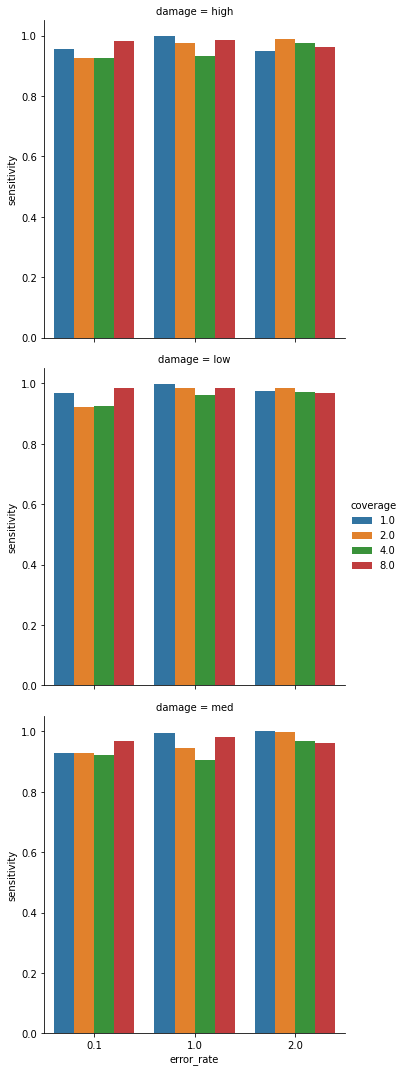

In [41]:
df_sens = dfres.groupby(["damage", "error_rate", "coverage"]).apply(sensitivity).to_frame("sensitivity").reset_index()

chart = sns.catplot(data=df_sens, y="sensitivity", x="error_rate", hue="coverage", kind="bar",row='damage', legend_out=True)

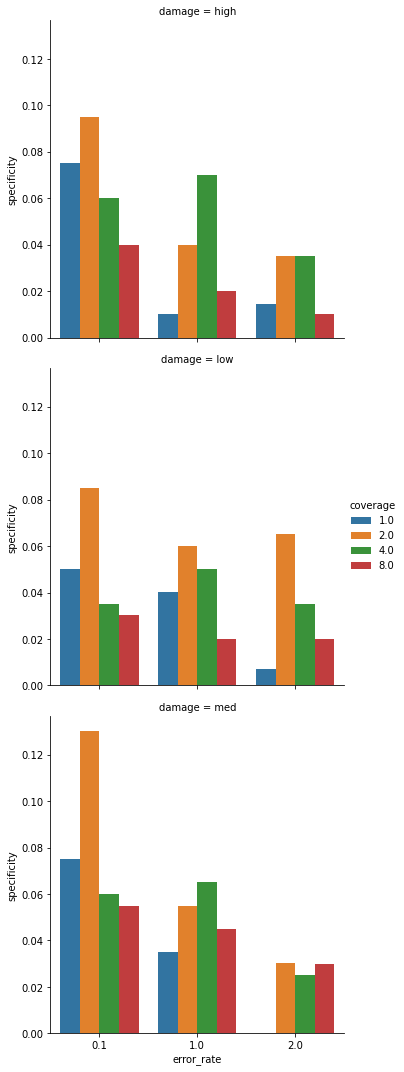

In [42]:
df_spe = dfres.groupby(["damage", "error_rate", "coverage"]).apply(specificity).to_frame("specificity").reset_index()
chart = sns.catplot(data=df_spe, y="specificity", x="error_rate", hue="coverage", row="damage", kind="bar", legend_out=True)